## Symbols Definitons
---

In [1]:

import numpy as np
from sympy import *
import matplotlib.pyplot as plt

#--- Model Parameters ---
d       = symbols('d',    real=True, positive=True)         # Distance between wheels
visc    = symbols('c_alpha',real=True)                      # Viscous, damping constant 
l       = symbols('l',    real=True, positive=True)         # Height of the COM
r       = symbols('r',    real=True, positive=True)         # Radius of the wheel
Mp      = symbols('M_p',  real=True, positive=True)         # Mass of the pendulum without the wheels
Mw      = symbols('M_w',  real=True, positive=True)         # Mass of each wheel
Iw_c    = symbols('I_wc',  real=True)                       # MOI wheel center
Iw_r    = symbols('I_wr',  real=True)                       # MOI wheel radial
Ip_x    = symbols('I_px',  real=True)                       # MOI pendulum x
Ip_y    = symbols('I_py',  real=True)                       # MOI pendulum y
Ip_z    = symbols('I_pz',  real=True)                       # MOI pendulum z

#--- Constants & Aux. variables ---
g = symbols('g', constant=True)                             # Gravity acceleration
t = symbols('t', real=True)                                 # Time

#--- State Variables ---
x           = symbols('x',  real=True)                      # Linear pos
pitch       = symbols('theta',  real=True)                  # Pitch angle
yaw         = symbols('psi',  real=True)                    # Yaw angle
x_vel       = Derivative(x,t)                               # Linear vel
pitch_vel   = Derivative(pitch,t)                           # Pitch vel
yaw_vel     = Derivative(yaw,t)                             # Yaw vel
x_acc       = Derivative(x_vel,t)                           # Linear acc
pitch_acc   = Derivative(pitch_vel,t)                       # Pitch acc
yaw_acc     = Derivative(yaw_vel,t)                         # Yaw acc

#--- Inputs ---
Tl = symbols('T_L', real=True)                              # Torque of the left wheel
Tr = symbols('T_R', real=True)                              # Torque of the right wheel

## Defining all the matrices of the system
----------

In [2]:

#*--- Matrices for the 3 states model
M = Matrix([[Mp+2*Mw+2*Iw_c/r**2, Mp*l*cos(pitch) ,                                                                     0],
            [ Mp*l*cos(pitch)   , Ip_y+Mp*l**2    ,                                                                     0],
            [0                  ,                0, Ip_z+2*Iw_r+(Mw+Iw_c/r**2)*d**2/2-(Ip_z-Ip_x-Mp*l**2)*sin(pitch)**2  ]])

C = Matrix([[                      0, -Mp*l*pitch_vel*sin(pitch),                          -Mp*l*yaw_vel*sin(pitch)],
            [                      0,                          0, (Ip_z-Ip_x-Mp*l**2)*yaw_vel*sin(pitch)*cos(pitch)],
            [Mp*l*yaw_vel*sin(pitch), -(Ip_z-Ip_x-Mp*l**2)*yaw_vel*sin(pitch)*cos(pitch), -(Ip_z-Ip_x-Mp*l**2)*pitch_vel*sin(pitch)*cos(pitch)]])

D = Matrix([[2*visc/r**2, -2*visc/r, 0],
            [-2*visc/r, 2*visc, 0],
            [0, 0, (d**2/(2*r**2))*visc]])

B = Matrix([[     1/r,     1/r],
            [      -1,      -1],
            [-d/(2*r), d/(2*r)]])

G = Matrix([[0],[-Mp*l*g*sin(pitch)], [0]])

q = Matrix([[x],[pitch],[yaw]])

q_diff = Matrix([[x_vel],[pitch_vel],[yaw_vel]])

q_2diff = Matrix([[x_acc],[pitch_acc],[yaw_acc]])

u = Matrix([[Tl],[Tr]])

In [3]:
M_inv = M.inv()

## Show system in expression form
---

In [4]:
# eqt_sys = M*q_2diff + (C+D)*q_diff + G - B*u
# eqt_sys
expr_model = M_inv*((B*u-G)-(C+D)*q_diff)
eqts_model = Eq(q_2diff,expr_model)
eqts_model

Eq(Matrix([
[    Derivative(x, (t, 2))],
[Derivative(theta, (t, 2))],
[  Derivative(psi, (t, 2))]]), Matrix([
[          -M_p*l*(M_p*g*l*sin(theta) - T_L - T_R - 2*c_alpha*Derivative(theta, t) + 2*c_alpha*Derivative(x, t)/r - (-I_px + I_pz - M_p*l**2)*sin(theta)*cos(theta)*Derivative(psi, t)**2)*cos(theta)/(-M_p**2*l**2*cos(theta)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)*(M_p*l*sin(theta)*Derivative(psi, t)**2 + T_L/r + T_R/r - 2*c_alpha*Derivative(x, t)/r**2 - (-M_p*l*sin(theta)*Derivative(theta, t) - 2*c_alpha/r)*Derivative(theta, t))/(-M_p**2*l**2*cos(theta)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[-M_p*l*(M_p*l*sin(theta)*Derivative(psi, t)**2 + T_L/r + T_R/r - 2*c_alpha*Derivative(x, t)/r**2 - (-M_p*l*sin(theta)*Derivative(theta, t) - 2*c_alpha/r)*Derivative(theta, t))*cos(theta)/(-M_p**2*l**2*cos(theta)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (2*I_wc/r**2 + M_p + 2*M_w)*(M_p*g*l*sin(theta) - T_L - T_R - 2*c_alpha*Derivati

In [5]:

#* Convert real variables into state-space variables

# Build state vector
real_state_vec = q_diff.row_insert(4,q)
state_vec = Matrix(list(symbols('x1:7',real=True)))
state_eq = Eq(state_vec,real_state_vec)
state_eq

Eq(Matrix([
[x1],
[x2],
[x3],
[x4],
[x5],
[x6]]), Matrix([
[    Derivative(x, t)],
[Derivative(theta, t)],
[  Derivative(psi, t)],
[                   x],
[               theta],
[                 psi]]))

In [6]:

#* Build the derivative of the state vector

real_state_diff_vec = q_2diff.row_insert(4,q_diff)
state_diff_vec = []
for sym in state_vec:
    state_diff_vec.append(Derivative(sym,t))
state_diff_vec = Matrix(state_diff_vec)
state_diff_eq = Eq(state_diff_vec,real_state_diff_vec)

#* Build the vector of system equations

system_equations = expr_model.row_insert(4,q_diff)

#* Substitute the real variables with the state-stape model variables: x1:x6

for i in range(6):
        system_equations = system_equations.subs(real_state_vec[i],state_vec[i])

#* Show the system of equations that will be used in the state space form 

eq_sys = Eq(state_diff_vec,system_equations)
eq_sys

Eq(Matrix([
[Derivative(x1, t)],
[Derivative(x2, t)],
[Derivative(x3, t)],
[Derivative(x4, t)],
[Derivative(x5, t)],
[Derivative(x6, t)]]), Matrix([
[          -M_p*l*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)*(M_p*l*x3**2*sin(x5) + T_L/r + T_R/r - 2*c_alpha*x1/r**2 - x2*(-M_p*l*x2*sin(x5) - 2*c_alpha/r))/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[-M_p*l*(M_p*l*x3**2*sin(x5) + T_L/r + T_R/r - 2*c_alpha*x1/r**2 - x2*(-M_p*l*x2*sin(x5) - 2*c_alpha/r))*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (2*I_wc/r**2 + M_p + 2*M_w)*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[                                        

In [7]:

#* Calcualte the jacobian for the A matrix of the continuos time system
Ac = Matrix(np.zeros((6,6)))

for i,expr in enumerate(system_equations):
    for j,state in enumerate(state_vec):
        Ac[i,j] = diff(expr,state)
Ac

Matrix([
[         -2*M_p*c_alpha*l*cos(x5)/(r*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))) - 2*c_alpha*(I_py + M_p*l**2)/(r**2*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))),            2*M_p*c_alpha*l*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)*(2*M_p*l*x2*sin(x5) + 2*c_alpha/r)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)),                 2*M_p*l*x3*(I_py + M_p*l**2)*sin(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + 2*M_p*l*x3*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5)**2/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)), 0,      2*M_p**3*l**3*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))*sin(x5)*cos(x5)**2/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))**2 - 2*M_p**2*l**2*(I_py + M_p*l**2)*(M_

In [8]:

#* Calcualte the jacobian for the B matrix of the continuos time system
Bc = Matrix(np.zeros((6,2)))

for i,expr in enumerate(system_equations):
    for j,torque in enumerate(u):
        Bc[i,j] = diff(expr,torque)
Bc

Matrix([
[           M_p*l*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)/(r*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))),            M_p*l*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)/(r*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)))],
[-M_p*l*cos(x5)/(r*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))) - (2*I_wc/r**2 + M_p + 2*M_w)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)), -M_p*l*cos(x5)/(r*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))) - (2*I_wc/r**2 + M_p + 2*M_w)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[                                                                                                          -d/(2*r*(I_pz + 2*I_wr + d**2*(I_wc/r**2 + M_w)/2 - (-I_px + I_pz - M_p*l**2)*sin(x5)**2

## Applying Model Parameters & Fixed Point
---

In [91]:

#* Evaluate Ac and Bc at the fixed points

fixed_point = [0,0,0,0,0,0] # Values for dx/dt
input_fixed_points = [0,0]

Ac_eval = Ac.subs([(state_vec[0], fixed_point[0]),
                   (state_vec[1], fixed_point[1]),
                   (state_vec[2], fixed_point[2]),
                   (state_vec[3], fixed_point[3]),
                   (state_vec[4], fixed_point[4]),
                   (state_vec[5], fixed_point[5]),
                   (Tl,input_fixed_points[0]),
                   (Tr,input_fixed_points[1])])

Bc_eval = Bc.subs([(state_vec[0], fixed_point[0]),
                   (state_vec[1], fixed_point[1]),
                   (state_vec[2], fixed_point[2]),
                   (state_vec[3], fixed_point[3]),
                   (state_vec[4], fixed_point[4]),
                   (state_vec[5], fixed_point[5]),
                   (Tl,input_fixed_points[0]),
                   (Tr,input_fixed_points[1])])

In [92]:
# Ac_eval
# Bc_eval

In [93]:

# Define the values of each Model Parameter

d_v    = (d,    0.1431)
visc_v = (visc, 0.01)
r_v    = (r,    0.05)
Mp_v   = (Mp,   2.036)
Mw_v   = (Mw,   0.268)
Iw_c_v = (Iw_c, 0.00033613)
Iw_r_v = (Iw_r, 0.00018876)
g_v    = (g,    9.81)

#-- Pose A ---
l_v    = (l,   0.1806)
Ip_x_v = (Ip_x, 0.02500992)
Ip_y_v = (Ip_y, 0.02255237)
Ip_z_v = (Ip_z, 0.00546422)

In [94]:

#* Plug in the Model parameters values 

Ac_lin = Ac_eval.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])
Bc_lin = Bc_eval.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])

Ac_np = np.array(Ac_lin) # Converts it into a numpy array
Bc_np = np.array(Bc_lin) # Converts it into a numpy array

## Discretization of the system 
---

It was used the Zero-Order Hold method. The system was also reduced to 4 states, eliminating the yaw and x positions, as was done in the SK8 Paper.

The formula used to calculate the **Bd** is in this [link](https://math.stackexchange.com/questions/658276/integral-of-matrix-exponential). It is the first fomula of the second answer.

In [95]:
from scipy import linalg

Ts = 0.01 # Sampling period. Fs = 100 hz

Ad = linalg.expm(Ac_np*Ts) # Matrix exponential fot the Zero-order Hold

Bd = np.eye(6)
for n in range(2,100):
    Bd = Bd + (Ac_np*Ts)**(n-1)/np.math.factorial(n)

Bd = np.matmul(Bd*Ts,Bc_np) #TODO Pq os sinais ficaram o contrário do artigo do SK8?

# Matrix(Ad)
# Matrix(Bd)


In [97]:

# Reduce the system to 4 states, only, ignoring the linear and Yaw positions

Ar = np.zeros((4,4))
Ar[0:3,0:3] =  Ad[0:3,0:3]
Ar[3,0:3]   = Ad[4,0:3]
Ar[0:3,3]   = Ad[0:3,4]
Ar[3,3]     = Ad[4,4]

Br = np.zeros((4,2))
Br[0:3,:]   = Bd[0:3,:]
Br[3,:]     = Bd[4,:]

In [98]:
# Matrix(Ar)
# Matrix(Br)

## Augmented System
---

## Control Analysis
---

In [15]:
import control
C_ss = np.diag([1,1,1,1,1,1])
D_ss = np.zeros((6,2))

ctrb_m = control.ctrb(Ad,Bd)
rank_ctrb = np.linalg.matrix_rank(ctrb_m) # If result is 4, the system is controlable

obs_m = control.obsv(Ad,C_ss)
rank_obs = np.linalg.matrix_rank(obs_m) # If result is 4, the system is controlable

print(rank_obs,rank_ctrb)


6 6


In [16]:

ss_system = control.ss(Ad,Bd,C_ss,D_ss)
# ss_system

In [86]:
Q_lqr = np.diag([1,1,1,1,1,1])
R_lqr = np.diag([1e15,1e15])

K_lqr, S_lqr, E_lqr = control.lqr(Ad,Bd,Q_lqr,R_lqr)

Matrix(K_lqr)
# type(K_lqr)

Matrix([
[2.97536278342568, -5.88336075260556, -0.648694505890705, -6.51198264443316, 7.91527708591412, -6.55533700616439],
[3.08181348384673, -5.76207188258024,  0.647865705315553, -5.28804683825926, 7.81020941124904, -4.35929815164486]])

In [99]:
Matrix(E_lqr)

Matrix([
[-0.869235038757324],
[ -1.07631540298462],
[-0.976456761360168],
[-0.959723651409149],
[              -1.0],
[              -1.0]])

## System Simulation
---

The simulation was done via te `scipy.integrate` module, using the `ode` class.

In [65]:

#* Apply model parameters to the system equations and jacobian

sys2sim = system_equations.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])
jac2sim = Ac.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])
# jac2sim

In [66]:
from scipy import integrate

state_initial_conditions = [0,0.01,0,0,0.07,0]
initial_inputs = [0,0]
t0 = 0

#* Create lambda functions of the system and the jacobian

func = lambdify([t, state_vec, u],sys2sim,'numpy')
func_jac = lambdify([t, state_vec, u],jac2sim,'numpy')

# func(0,state_initial_conditions, initial_inputs)
# func_jac(0,state_initial_conditions, initial_inputs)

In [87]:

simulator = integrate.ode(func, func_jac)                           # Ode class object used for simulation
simulator.set_initial_value(state_initial_conditions, t0)           # Set initial consitions of the system
simulator.set_integrator('vode',method= 'bdf',order=5)
simulator.set_f_params(initial_inputs)                              # Set the initial inputs (wheel torques) values in the system
simulator.set_jac_params(initial_inputs)                            # Set the initial inputs (wheel torques) values in the jacobian

def call_controller(current_states):                                # Function to call the controller
    # control_states = np.zeros((4,))
    # control_states[0:3] = current_states[0:3]
    # control_states[3] = current_states[4]
    current_inputs = np.matmul(-1*K_lqr,current_states).reshape(2,1)
    # print(current_inputs,current_inputs.shape)
    return current_inputs

    # return np.array([0,0]).reshape(2,1)

t1 = 10                                                           # Max. time for simulation  
dt = 0.01                                                      # Simulation time step
controller_time = -1                                                # Initial controller time (-1 means: "provide a control effort based on the initial states") 
controller_calls = 0                                                # Counts how many times the controller was called (just debug)

history = np.array([state_initial_conditions]).reshape(6,1)
time_history = [t0]
input_history = np.array(initial_inputs).reshape(2,1)

control_states = np.zeros((4,))

while simulator.successful() and simulator.t <= t1:                 # Simulation main loop
    history = np.hstack((history,np.array([simulator.integrate(simulator.t+dt)]).reshape(6,1)))        # Simulate one time step and save in history
    time_history.append(simulator.t+dt)
    
    input_history = np.hstack((input_history,call_controller(history[:,-1])))     # Call the controller
    controller_calls += 1
    
    # control_states[0:3] = history[0:3,-1]
    # control_states[3] = history[4,-1]
    # current_inputs = np.matmul(-1*K_lqr,history[:,-1]).reshape(2,)
    
    simulator.set_f_params(input_history[:,-1])                          # Update the controller values in the systems equations
    simulator.set_jac_params(input_history[:,-1])                     # Update the controller values in the jacobian matrix

    # controller_time += dt
    # if(controller_time >= Ts or controller_time < 0):
    #     controller_calls += 1
    #     current_inputs = call_controller(current_states)
    #     simulator.set_f_params(current_inputs)
    #     simulator.set_jac_params(current_inputs)
    #     controller_time = 0 
    
print(simulator.get_return_code())
# history_file = open("simulation_data.txt",'w')
# history_file.write(str(time_history))
# history_file.write("\n")
# history_file.write(str(list(history)))

-4


In [88]:
len(time_history)

5

## Plotting & Animation
----

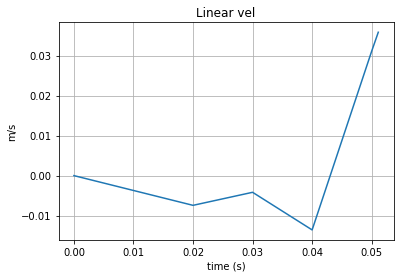

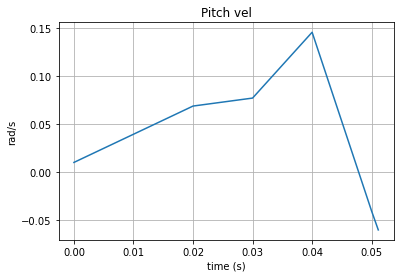

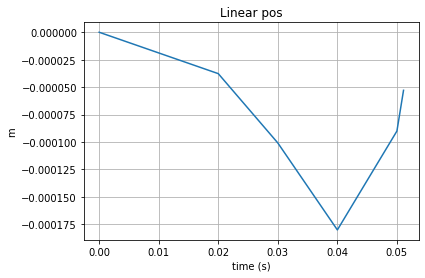

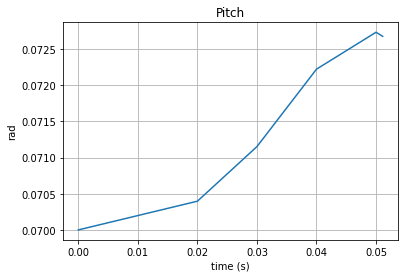

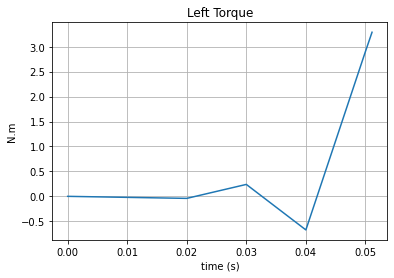

In [74]:
fig1 = plt.figure()
plt.plot(time_history,history[0,:])
plt.title("Linear vel")
plt.xlabel("time (s)")
plt.ylabel("m/s")
plt.grid()

fig2 = plt.figure()
plt.plot(time_history,history[1,:])
plt.title("Pitch vel")
plt.xlabel("time (s)")
plt.ylabel("rad/s")
plt.grid()

fig3 = plt.figure()
plt.plot(time_history,history[3,:])
plt.title("Linear pos")
plt.xlabel("time (s)")
plt.ylabel("m")
plt.grid()

fig4 = plt.figure()
plt.plot(time_history,history[4,:])
plt.title("Pitch")
plt.xlabel("time (s)")
plt.ylabel("rad")
plt.grid()

fig5 = plt.figure()
plt.plot(time_history,input_history[0,:])
plt.title("Left Torque")
plt.xlabel("time (s)")
plt.ylabel("N.m")
plt.grid()

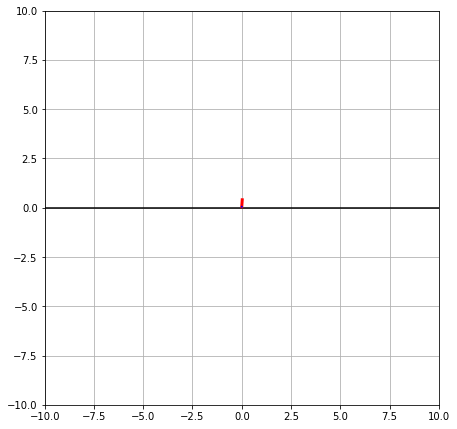

In [59]:

from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation

xlim = (-10,10)
ylim = (-10,10)

fig = plt.figure(figsize=(8.3333, 7.25), dpi=72) #figsize=(8.3333, 7.25), dpi=72
ax = fig.add_subplot(111,xlim=xlim,ylim=ylim)
ax.set_aspect('equal')
ax.grid()

height = 0.354

ax.plot([xlim[0],xlim[1]],[0,0],'-k')         # Ground

pend_rod, = ax.plot([history[3,0], history[3,0]+height*np.math.sin(history[4,0])],[r_v[1],r_v[1] + height*np.math.cos(history[4,0])], 'r', lw=3)
pend_wheel = ax.add_patch(Circle((history[3,0],r_v[1]), r_v[1], fc='b', zorder=3))

def init_anim():
  pend_rod, = ax.plot([history[3,0], history[3,0]+height*np.math.sin(history[4,0])],[r_v[1],r_v[1] + height*np.math.cos(history[4,0])], 'r', lw=3)
  pend_wheel = ax.add_patch(Circle((history[3,0],r_v[1]), r_v[1], fc='b', zorder=3))
  return pend_rod, pend_wheel
  
def animate(i):
  xaxis = [history[3,i], history[3,i] + height*np.math.sin(history[4,i])]
  yaxis = [r_v[1], r_v[1] + height*np.math.cos(history[4,i])]
  
  pend_rod.set_data(xaxis,yaxis)
  pend_wheel.set_center((history[3,i],r_v[1]))
  return pend_rod, pend_wheel

anim = FuncAnimation(fig, animate,frames=len(time_history),interval=200,blit=True)

In [60]:
anim.save("model_animation1.gif",fps=36)

## View all matrices
----

In [26]:
M

Matrix([
[2*I_wc/r**2 + M_p + 2*M_w, M_p*l*cos(theta),                                                                                  0],
[         M_p*l*cos(theta),  I_py + M_p*l**2,                                                                                  0],
[                        0,                0, I_pz + 2*I_wr + d**2*(I_wc/r**2 + M_w)/2 - (-I_px + I_pz - M_p*l**2)*sin(theta)**2]])

In [27]:
C

Matrix([
[                                  0,                            -M_p*l*sin(theta)*Derivative(theta, t),                                -M_p*l*sin(theta)*Derivative(psi, t)],
[                                  0,                                                                 0,  (-I_px + I_pz - M_p*l**2)*sin(theta)*cos(theta)*Derivative(psi, t)],
[M_p*l*sin(theta)*Derivative(psi, t), (I_px - I_pz + M_p*l**2)*sin(theta)*cos(theta)*Derivative(psi, t), (I_px - I_pz + M_p*l**2)*sin(theta)*cos(theta)*Derivative(theta, t)]])

In [28]:
D

Matrix([
[2*c_alpha/r**2, -2*c_alpha/r,                     0],
[  -2*c_alpha/r,    2*c_alpha,                     0],
[             0,            0, c_alpha*d**2/(2*r**2)]])

In [29]:
B

Matrix([
[     1/r,     1/r],
[      -1,      -1],
[-d/(2*r), d/(2*r)]])

In [30]:
G

Matrix([
[                  0],
[-M_p*g*l*sin(theta)],
[                  0]])

In [31]:
u

Matrix([
[T_L],
[T_R]])